<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [49]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-02-22 14:54:38--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-02-22 14:54:38 (116 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [50]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [51]:
df.shape

(346, 10)

### Convert to date time object


In [52]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [53]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [54]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

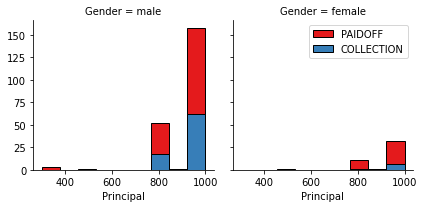

In [55]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

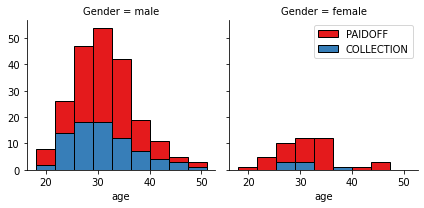

In [56]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


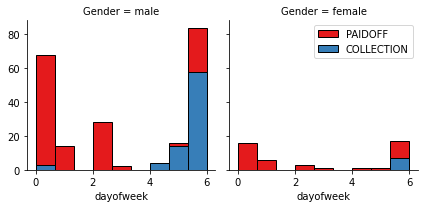

In [57]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [58]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [59]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [60]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [61]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [62]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [63]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [64]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [65]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [66]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [67]:
#Select train and test subsets with default 0.25 test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

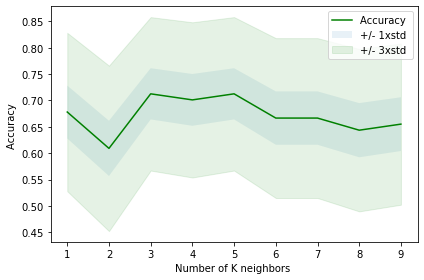

K: 3 with max accuracy 0.7126436781609196


In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#To choose the best k and plotting it
ks = 10
mean_acc = np.zeros((ks-1))
std_acc = np.zeros((ks-1))
for n in range(1, ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,ks), mean_acc, 'g')
plt.fill_between(range(1,ks), mean_acc-1 * std_acc, mean_acc+1 * std_acc, alpha=0.10)
plt.fill_between(range(1,ks), mean_acc-3 * std_acc, mean_acc+3 * std_acc, alpha=0.10, color='green')
plt.legend(('Accuracy ', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of K neighbors ')
plt.tight_layout()
plt.show()

#We compute the max and its accuracy
print('K:', mean_acc.argmax()+1, 'with max accuracy', mean_acc.max())


In [69]:
#Best model with its accuracy
k = 3
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
yhat = neigh.predict(X_test)

print('Train set accuracy:', metrics.accuracy_score(y_train, neigh.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, yhat))

#after training, we use all data to build the model
neigh_complete = KNeighborsClassifier(n_neighbors=k).fit(X, y)
yhat_complete = neigh_complete.predict(X)

print('Model accuracy:', metrics.accuracy_score(y, yhat_complete))

Train set accuracy: 0.8455598455598455
Test set accuracy: 0.7126436781609196
Model accuracy: 0.815028901734104


# Decision Tree


In [70]:
#Select train and test subsets with default 0.25 test set
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

In [71]:
#building the model based on entropy and checking its accuracy
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
tree.fit(X_train, y_train)
predtree = tree.predict(X_test)
print('Model accuracy:', metrics.accuracy_score(y_test, predtree))

Model accuracy: 0.7011494252873564


# Support Vector Machine


In [72]:
#Select train and test subsets with default 0.25 test set
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

In [73]:
#building the model with different kernels
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
yhat_rbf = clf_rbf.predict(X_test)

clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)
yhat_linear = clf_linear.predict(X_test)

clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train)
yhat_poly = clf_poly.predict(X_test)

clf_sigmoid = svm.SVC(kernel='sigmoid')
clf_sigmoid.fit(X_train, y_train)
yhat_sigmoid = clf_sigmoid.predict(X_test)

In [74]:
#evaluation of the models' accuracy
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
print('F1-score for rfb kernel:', f1_score(y_test, yhat_rbf, average='weighted'))
print('Jaccard score for rfb kernel:', jaccard_score(y_test, yhat_rbf, pos_label='PAIDOFF'))

print('F1-score for linear kernel:', f1_score(y_test, yhat_linear, average='weighted'))
print('Jaccard score for linear kernel:', jaccard_score(y_test, yhat_linear, pos_label='PAIDOFF'))

print('F1-score for polynomial kernel:', f1_score(y_test, yhat_poly, average='weighted'))
print('Jaccard score for polynomial kernel:', jaccard_score(y_test, yhat_poly, pos_label='PAIDOFF'))

print('F1-score for sigmoid kernel:', f1_score(y_test, yhat_sigmoid, average='weighted'))
print('Jaccard score for sigmoid kernel:', jaccard_score(y_test, yhat_sigmoid, pos_label='PAIDOFF'))

F1-score for rfb kernel: 0.6179310344827587
Jaccard score for rfb kernel: 0.7241379310344828
F1-score for linear kernel: 0.6235822486107939
Jaccard score for linear kernel: 0.735632183908046
F1-score for polynomial kernel: 0.6122039651315281
Jaccard score for polynomial kernel: 0.7126436781609196
F1-score for sigmoid kernel: 0.600516068496364
Jaccard score for sigmoid kernel: 0.6896551724137931


# Logistic Regression


In [75]:
#Select train and test subsets with default 0.25 test set
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

In [76]:
#building the model using different solvers
LR_linear = LogisticRegression(C=0.01, solver='liblinear')
LR_linear.fit(X_train, y_train)
yhat_liblinear = LR_linear.predict(X_test)
yhat_prob_linear = LR_linear.predict_proba(X_test)

LR_sag = LogisticRegression(C=0.01, solver='sag')
LR_sag.fit(X_train, y_train)
yhat_sag = LR_sag.predict(X_test)
yhat_prob_sag = LR_sag.predict_proba(X_test)

LR_saga = LogisticRegression(C=0.01, solver='saga')
LR_saga.fit(X_train, y_train)
yhat_saga = LR_saga.predict(X_test)
yhat_prob_saga = LR_saga.predict_proba(X_test)

LR_lbfgs = LogisticRegression(C=0.01, solver='lbfgs')
LR_lbfgs.fit(X_train, y_train)
yhat_lbfgs = LR_lbfgs.predict(X_test)
yhat_prob_lbfgs = LR_lbfgs.predict_proba(X_test)

LR_newton = LogisticRegression(C=0.01, solver='newton-cg')
LR_newton.fit(X_train, y_train)
yhat_newton = LR_newton.predict(X_test)
yhat_prob_newton = LR_newton.predict_proba(X_test)

In [77]:
#evaluate different logistic regression models
from sklearn.metrics import log_loss
print('Jaccard score:', jaccard_score(y_test, yhat_liblinear, pos_label='PAIDOFF'), 'for solver liblinear')
print('LogLoss:', log_loss(y_test, yhat_prob_linear), 'for solver liblinear')
      
print('Jaccard score:', jaccard_score(y_test, yhat_sag, pos_label='PAIDOFF'), 'for solver sag')
print('LogLoss:', log_loss(y_test, yhat_prob_sag), 'for solver sag')
      
print('Jaccard score:', jaccard_score(y_test, yhat_saga, pos_label='PAIDOFF'), 'for solver saga')
print('LogLoss:', log_loss(y_test, yhat_prob_saga), 'for solver saga')
      
print('Jaccard score:', jaccard_score(y_test, yhat_lbfgs, pos_label='PAIDOFF'), 'for solver lbfgs')
print('LogLoss:', log_loss(y_test, yhat_prob_lbfgs), 'for solver lbfgs')
      
print('Jaccard score:', jaccard_score(y_test, yhat_newton, pos_label='PAIDOFF'), 'for solver newton-cg')
print('LogLoss:', log_loss(y_test, yhat_prob_newton), 'for solver newton-cg')

Jaccard score: 0.7195121951219512 for solver liblinear
LogLoss: 0.5790271677565116 for solver liblinear
Jaccard score: 0.735632183908046 for solver sag
LogLoss: 0.5258996807544497 for solver sag
Jaccard score: 0.735632183908046 for solver saga
LogLoss: 0.525899495856861 for solver saga
Jaccard score: 0.735632183908046 for solver lbfgs
LogLoss: 0.5259003751939373 for solver lbfgs
Jaccard score: 0.735632183908046 for solver newton-cg
LogLoss: 0.5259003842066071 for solver newton-cg


In [78]:
#Since liblinear seems the best option, we try different values of C
LR_linear_001 = LogisticRegression(C=0.001, solver='liblinear')
LR_linear_001.fit(X_train, y_train)
yhat_liblinear_001 = LR_linear_001.predict(X_test)
yhat_prob_linear_001 = LR_linear_001.predict_proba(X_test)

LR_linear_0001 = LogisticRegression(C=0.0001, solver='liblinear')
LR_linear_0001.fit(X_train, y_train)
yhat_liblinear_0001 = LR_linear_0001.predict(X_test)
yhat_prob_linear_0001 = LR_linear_0001.predict_proba(X_test)

#new models' evaluation
print('Jaccard score:', jaccard_score(y_test, yhat_liblinear_001, pos_label='PAIDOFF'), 'for solver liblinear and C=0.001')
print('LogLoss:', log_loss(y_test, yhat_prob_linear_001), 'for solver liblinear and C=0.001')

print('Jaccard score:', jaccard_score(y_test, yhat_liblinear_0001, pos_label='PAIDOFF'), 'for solver liblinear and C=0.0001')
print('LogLoss:', log_loss(y_test, yhat_prob_linear_0001), 'for solver liblinear and C=0.0001')

Jaccard score: 0.7088607594936709 for solver liblinear and C=0.001
LogLoss: 0.671774557119714 for solver liblinear and C=0.001
Jaccard score: 0.7088607594936709 for solver liblinear and C=0.0001
LogLoss: 0.6908102845387178 for solver liblinear and C=0.0001


# Model Evaluation using Test set


In [79]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [80]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-22 14:54:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-22 14:54:43 (70.7 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [81]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [82]:
#Accuracy for KNN model
print('Jaccard score for KNN algorithm:', jaccard_score(y_test, yhat, pos_label='PAIDOFF'))
print('F1 score for KNN algorithm:', f1_score(y_test, yhat, average='weighted'))

Jaccard score for KNN algorithm: 0.6753246753246753
F1 score for KNN algorithm: 0.71056461433366


In [83]:
#Accuracy for Decision Tree
print('Jaccard score for Decision Tree model:', jaccard_score(y_test, predtree, pos_label='PAIDOFF'))
print('F1 score for Decision Tree model:', f1_score(y_test, predtree, average='weighted'))

Jaccard score for Decision Tree model: 0.6578947368421053
F1 score for Decision Tree model: 0.7050036489691661


In [84]:
#Accuracy for SVM
print('Jaccard score for best SVM model (linear kernel):', jaccard_score(y_test, yhat_linear, pos_label='PAIDOFF'))
print('F1 score for best SVM model (linear kernel):', f1_score(y_test, yhat_linear, average='weighted'))

Jaccard score for best SVM model (linear kernel): 0.735632183908046
F1 score for best SVM model (linear kernel): 0.6235822486107939


In [85]:
#Accuracy for Logistic Regression
from sklearn.metrics import classification_report
print('Jaccard score for the best Logistic Regression model (solver liblinear and C=0.001):', jaccard_score(y_test, yhat_liblinear_001, pos_label='PAIDOFF'))
print('F1 score for the best Logistic Regression model (solver liblinear and C=0.001):', f1_score(y_test, yhat_liblinear_001, average='weighted'))
print('LogLoss for the best Logistic Regression model (solver liblinear and C=0.001):', log_loss(y_test, yhat_prob_linear_001))

Jaccard score for the best Logistic Regression model (solver liblinear and C=0.001): 0.7088607594936709
F1 score for the best Logistic Regression model (solver liblinear and C=0.001): 0.7187608474964797
LogLoss for the best Logistic Regression model (solver liblinear and C=0.001): 0.671774557119714


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
